# Convolutional Neural Network Pneumonia Prediction

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt

## Exploring the data

In [2]:
basedir = os.path.join('/Users/lukemorrice/Projects', 'ChestXRays')
train_dir = os.path.join(basedir, 'train')
val_dir = os.path.join(basedir, 'val')
test_dir = os.path.join(basedir, 'test')

In [3]:
train_norm_dir = os.path.join(train_dir, 'NORMAL')
train_ill_dir = os.path.join(train_dir, 'PNEUMONIA')

val_norm_dir = os.path.join(val_dir, 'NORMAL')
val_ill_dir = os.path.join(val_dir, 'PNEUMONIA')

test_norm_dir = os.path.join(test_dir, 'NORMAL')
test_ill_dir = os.path.join(test_dir, 'PNEUMONIA')

In [4]:
num_norm_tr = len(os.listdir(train_norm_dir))
num_ill_tr = len(os.listdir(train_ill_dir))

num_norm_val = len(os.listdir(val_norm_dir))
num_ill_val = len(os.listdir(val_ill_dir))

num_norm_tst = len(os.listdir(test_norm_dir))
num_ill_tst = len(os.listdir(test_ill_dir))

total_train = num_norm_tr + num_ill_tr
total_val = num_norm_val + num_ill_val
total_test = num_norm_tst + num_norm_tst

In [5]:
print('Training normal images:', num_norm_tr)
print('Training ill images:', num_ill_tr)
print('')
print('Val normal images:', num_norm_val)
print('Val ill images:', num_ill_val)
print('')
print('Test normal images:', num_norm_tst)
print('Test ill images:', num_ill_tst)

Training normal images: 1341
Training ill images: 3875

Val normal images: 217
Val ill images: 390

Test normal images: 27
Test ill images: 26


## Setting Model Parameters

In [6]:
# Randomly assigning batch size for now
BATCH_SIZE = 32
# Each image will be 500x500 in size
IMG_SHAPE = 64

In [7]:
# Plots images with 1 row and 5 columns
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Horizontal Image Flipping

In [8]:
# Create an image generator from train_dir
# Normalise pixel values, flip some horizontally, and shuffle order
# Also resize the images to be consistent for the CNN
image_gen = ImageDataGenerator(rescale=1/255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=train_dir,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                              class_mode='binary')

Found 5216 images belonging to 2 classes.


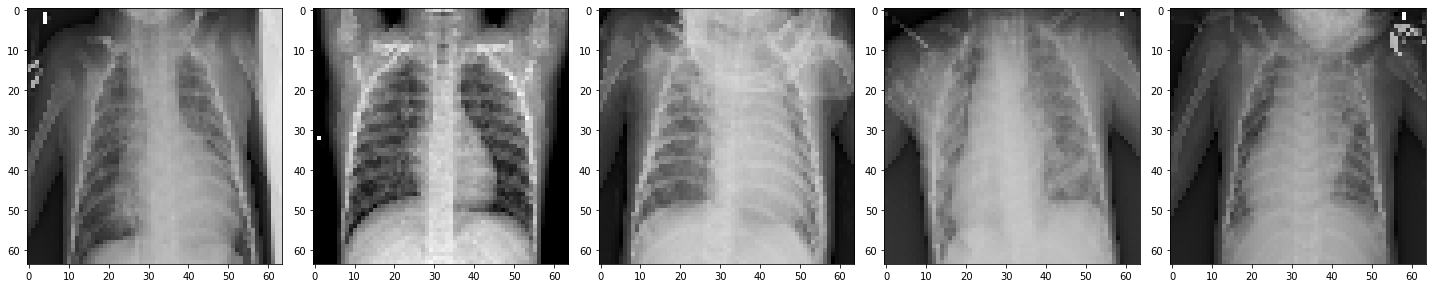

In [9]:
augmented_imgs = [train_data_gen[0][0][i] for i in range(5)]
plotImages(augmented_imgs)

### Applying Zoom

In [10]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.2)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=train_dir,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE, IMG_SHAPE))

Found 5216 images belonging to 2 classes.


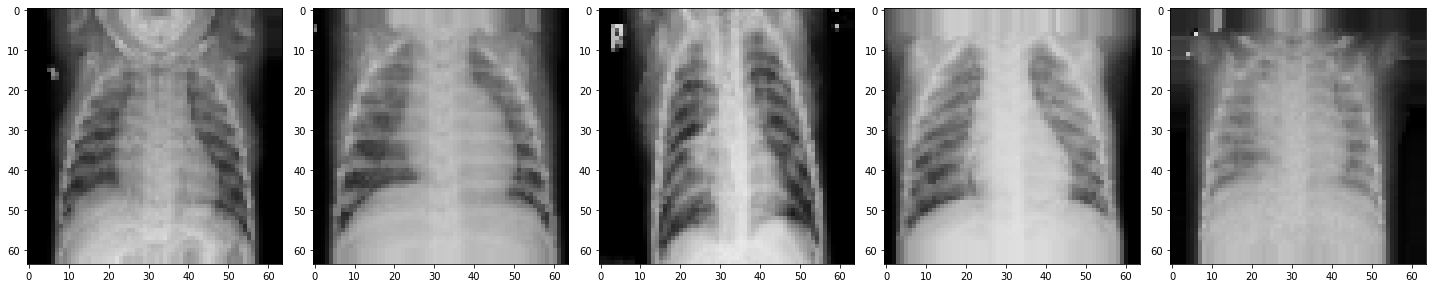

In [11]:
augmented_imgs = [train_data_gen[0][0][i] for i in range(5)]
plotImages(augmented_imgs)

### Combining Both

In [12]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2, 
    horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=train_dir,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                              class_mode='binary')

Found 5216 images belonging to 2 classes.


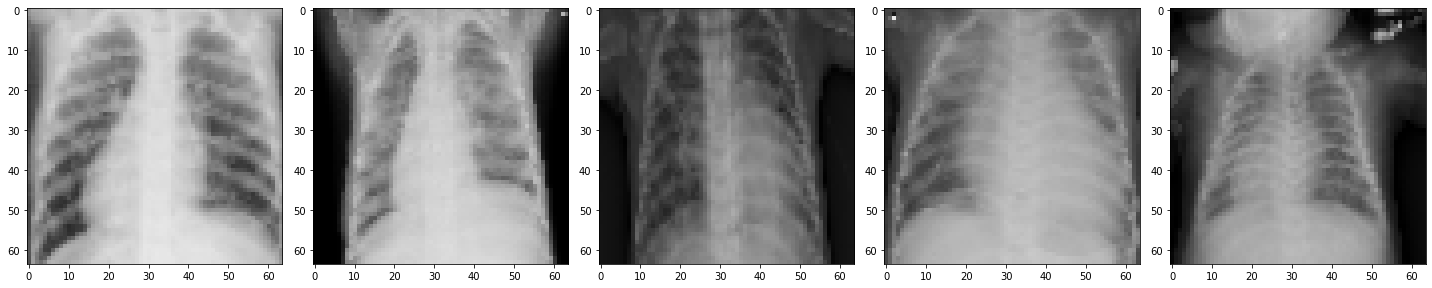

In [13]:
augmented_images = [train_data_gen[0][0][i] for i in range(5)]
plotImages(augmented_images)

### Validation Data Generator

In [14]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                directory=val_dir,
                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                class_mode='binary')

Found 606 images belonging to 2 classes.


## Creating the Model

Creating the model using 2 convolution blocks (with a max pooling layer in each) and the relu activation function. Also added a dropout layer afterwards to prevent overfitting.

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [16]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

## Training the Model

In [17]:
EPOCHS = 10
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
163/163 [==============================] - 70s 429ms/step - loss: 0.4220 - accuracy: 0.8079 - val_loss: 0.4702 - val_accuracy: 0.7921
Epoch 2/10
163/163 [==============================] - 61s 376ms/step - loss: 0.2574 - accuracy: 0.8938 - val_loss: 0.4645 - val_accuracy: 0.8020
Epoch 3/10
163/163 [==============================] - 61s 375ms/step - loss: 0.2158 - accuracy: 0.9128 - val_loss: 0.3655 - val_accuracy: 0.8548
Epoch 4/10
163/163 [==============================] - 61s 375ms/step - loss: 0.2317 - accuracy: 0.9066 - val_loss: 0.4059 - val_accuracy: 0.8119
Epoch 5/10
163/163 [==============================] - 61s 376ms/step - loss: 0.2002 - accuracy: 0.9179 - val_loss: 0.4519 - val_accuracy: 0.8498
Epoch 6/10
163/163 [==============================] - 61s 375ms/step - loss: 0.1960 - accuracy: 0.9197 - val_loss: 0.5280 - val_accuracy: 0.8317
Epoch 7/10
163/163 [==============================] - 

In [18]:
test_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                directory=test_dir,
                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                class_mode='binary')

test_accu = model.evaluate_generator(test_data_gen)
print('Accuracy on test set:        ', round(test_accu[1]*100, 2), '%')

Found 52 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
Accuracy on test set:         84.62 %


## Visualising Results

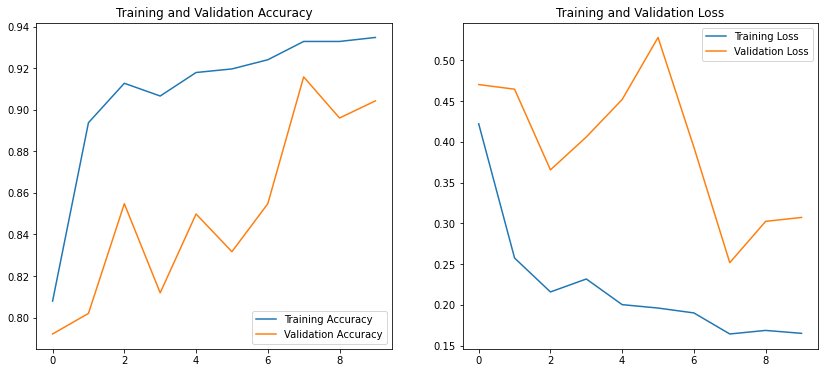

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Transfer Learning

### MobileNet

In [20]:
import tensorflow_hub as hub
IMAGE_RES = 224
URL = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3), trainable=False)

In [21]:
BATCH_SIZE = 32

image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2, 
    horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=train_dir,
                                              shuffle=True,
                                              target_size=(IMAGE_RES, IMAGE_RES),
                                              class_mode='binary')

image_gen = ImageDataGenerator(
    rescale=1./255)

val_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=val_dir,
                                              target_size=(IMAGE_RES, IMAGE_RES),
                                              class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 606 images belonging to 2 classes.


In [22]:
model_net = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(2)
])

In [23]:
model_net.compile(optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

EPOCHS = 10

model_net.fit(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen)

Epoch 1/10
163/163 [==============================] - 292s 2s/step - loss: 7.5416 - accuracy: 0.7444 - val_loss: 6.0182 - val_accuracy: 0.6452
Epoch 2/10
163/163 [==============================] - 249s 2s/step - loss: 6.3616 - accuracy: 0.7439 - val_loss: 5.7984 - val_accuracy: 0.6452
Epoch 3/10
163/163 [==============================] - 240s 1s/step - loss: 6.4012 - accuracy: 0.7460 - val_loss: 5.8601 - val_accuracy: 0.6452
Epoch 4/10
163/163 [==============================] - 239s 1s/step - loss: 6.1440 - accuracy: 0.7450 - val_loss: 5.5701 - val_accuracy: 0.6469
Epoch 5/10
163/163 [==============================] - 236s 1s/step - loss: 6.2524 - accuracy: 0.7460 - val_loss: 5.6497 - val_accuracy: 0.6469
Epoch 6/10
163/163 [==============================] - 235s 1s/step - loss: 9.0520 - accuracy: 0.4983 - val_loss: 9.9269 - val_accuracy: 0.3564
Epoch 7/10
163/163 [==============================] - 237s 1s/step - loss: 11.4593 - accuracy: 0.2571 - val_loss: 9.9269 - val_accuracy: 0.356

Clearly, the Transfer Learning model is not great in this scenario. Perhaps a different feature vector would produce better results. Ultimately, I was just curious how it would perform for this use case and so it was just a test.